# One-shot one-step LSTM Model on Cascadia
Author: Camilla Billari <br> 
Date: 27/01/24

Fitting a one-shot multi-step LSTM to the Cascadia dataset.

In [1]:
# Import relevant libraries
import sys
import matplotlib.pyplot as plt
import numpy as np
import local_paths

# Change local path
sys.path.append(local_paths.MAIN_DIRECTORY)

# Import local modules - note: dependent on above path being set.
from utils.dataset import SlowEarthquakeDataset
import scripts.general_functions as gfn
import scripts.lstm_oneshot_multistep as lstm

In [2]:
# Set random seed
SEED = 17 # random seed for the dataset and model
gfn.set_seed(SEED)

# Set torch device
device = gfn.set_torch_device()

No GPU available.


## Load Data

In [3]:
EXP = "cascadia_1_seg" # select cascadia segment 1

# Load dataset and convert to dataframe
dataset = SlowEarthquakeDataset([EXP])
df = SlowEarthquakeDataset.convert_to_df(dataset, EXP)

df.head()

,seg_avg,seg_0,seg_1,seg_2,seg_3,seg_4,seg_5,seg_6,seg_7,seg_8,...,seg_187,seg_188,seg_189,seg_190,seg_191,seg_192,seg_193,seg_194,seg_195,time
0,1.510314e+08,87022.678176,-51216.196044,-195371.505863,-252388.298108,372090.056832,290238.755195,271991.646241,218795.685053,87096.609524,...,-714770.112748,-631423.743396,-693599.810348,-7.208255e+05,-739527.228854,-471014.225482,-6.757540e+05,-350155.612260,-517024.526987,2007.000700
1,1.256806e+08,118857.552212,64765.192887,-66943.170211,-125253.475061,510980.726973,375269.217942,323695.517273,312924.577753,-6911.497818,...,-506075.873333,-448764.275644,-391456.474306,-9.886575e+05,-958004.348328,-740390.446945,-8.927657e+05,-466337.939160,-928475.702850,2007.003438
2,1.074901e+08,-113120.619296,-100329.909243,-117236.092138,-63257.566664,87699.655400,15131.208777,-22576.356489,-13975.055467,-177396.925200,...,-421853.932989,-333693.022748,-204519.903296,-7.137062e+05,-715494.785171,-542145.799983,-6.803446e+05,-366915.287037,-572674.592498,2007.006176
3,1.447256e+08,-51897.143096,-61146.543996,-108560.424295,-80686.019435,178525.612880,98101.791008,48849.079713,53199.150697,-139909.026614,...,-655215.504038,-473799.573780,-345621.989210,-9.187762e+05,-927868.499626,-679886.516377,-8.823582e+05,-474262.121982,-695698.483285,2007.008914
4,1.787377e+08,-60139.943735,-118351.239477,-228181.280629,-226276.200039,270908.204014,154758.192851,92016.023222,86065.362414,-174784.005040,...,-916992.338832,-753637.001609,-546489.401328,-1.036981e+06,-934869.092836,-938970.117667,-1.106399e+06,-800182.900760,-897332.083419,2007.011651


In [4]:
# Select segment average and scale down by 10^8
df_seg_1 = df["seg_avg"]/1e8

df_seg_1.shape

(3883,)

## Data Pre-processing

### Denoising

In [5]:
# Data smoothing
SMOOTHING_WINDOW = 5 # moving average window size
DOWNSAMPLING_FACTOR = 1

# Smooth the data
df_smoothed = gfn.moving_average_causal_filter(df_seg_1, SMOOTHING_WINDOW, DOWNSAMPLING_FACTOR)

df_smoothed.shape

(3859,)

In [6]:
# Check if smoothed results are statistically significantly different
results = gfn.compare_feature_statistics(df_seg_1, df_smoothed)
print(results)

{'mean_comparison': {'t_statistic': 0.1264999853610685, 'p_value': 0.8993394464426949, 'significant': False}, 'variance_comparison': {'f_statistic': 0.016002246296350102, 'p_value': 0.8993394464428732, 'significant': False}}


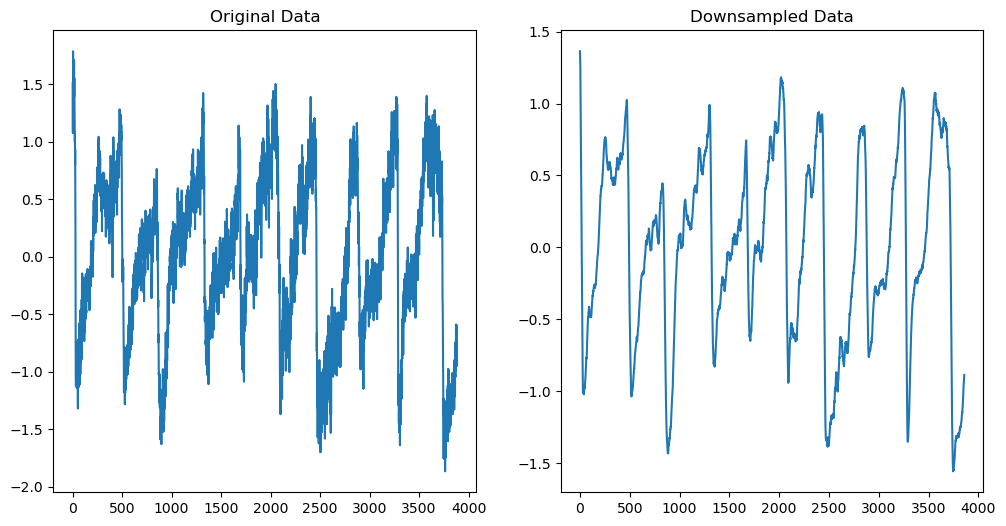

In [7]:
# Plot relevant features in the original and downsampled datasets
plt.figure(figsize=(12, 6))

# Example: Plotting the first feature in the dataset
plt.subplot(1, 2, 1)
plt.plot(
    range(len(df_seg_1)), df_seg_1, label="Original Data"
)
plt.title("Original Data")

plt.subplot(1, 2, 2)
plt.plot(
    range(len(df_smoothed)),
    df_smoothed,
    label="Downsampled Data"
)
plt.title("Downsampled Data")

plt.show()

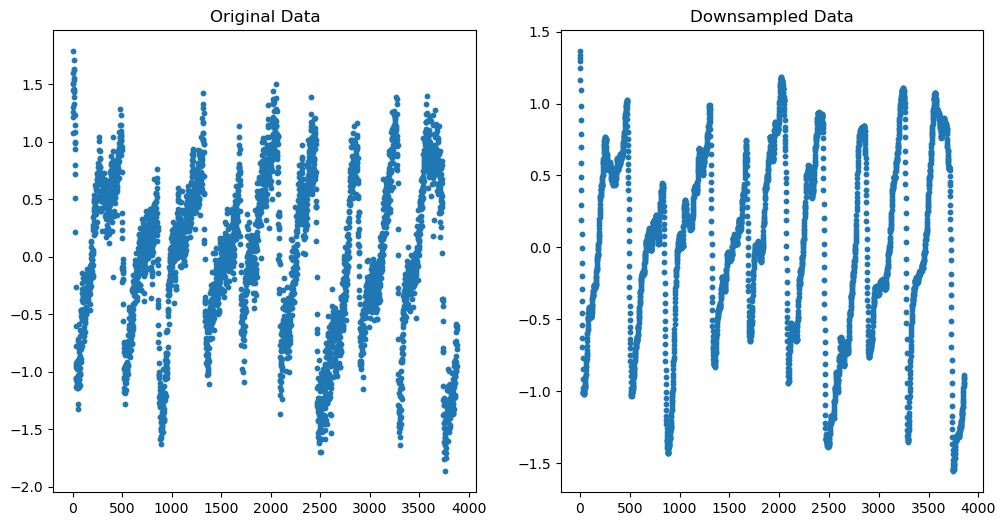

In [8]:
# Plot relevant features in the original and downsampled datasets
plt.figure(figsize=(12, 6))

# Example: Plotting the first feature in the dataset
plt.subplot(1, 2, 1)
plt.scatter(
    range(len(df_seg_1)), df_seg_1, label="Original Data",
    s=10,
)
plt.title("Original Data")

plt.subplot(1, 2, 2)
plt.scatter(
    range(len(df_smoothed)),
    df_smoothed,
    label="Downsampled Data",
    s=10,

)
plt.title("Downsampled Data")

plt.show()

## Creating the datastet

In [9]:
# Dataset parameters
LOOKBACK, FORECAST = 150, 14 # lookback and forecast values
N_FORECAST_WINDOWS = 30 # n forecasted windows in test set

# Pre-process the data into windows
X, y = gfn.create_dataset(df_smoothed, LOOKBACK, FORECAST)

print(f"X and y shapes: {X.shape}, {y.shape}")

X and y shapes: torch.Size([3696, 150]), torch.Size([3696, 14])


In [10]:
# Split into train and test sets and normalise it
X_train, y_train, X_test, y_test = gfn.split_train_test_forecast_windows(X, y, FORECAST, N_FORECAST_WINDOWS)

# Display shapes of the created datasets
print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
print(f"Testing data shapes: {X_test.shape}, {y_test.shape}")

Training data shapes: torch.Size([3276, 150]), torch.Size([3276, 14])
Testing data shapes: torch.Size([420, 150]), torch.Size([420, 14])


### Normalising with scaler based on the training set

In [11]:
# Normalise the dataset and save all sets into data_dict; keep scalers for later.
data_dict, scaler_X, scaler_y = gfn.normalise_dataset(X_train, y_train, X_test, y_test)

print(data_dict.keys())

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc'])


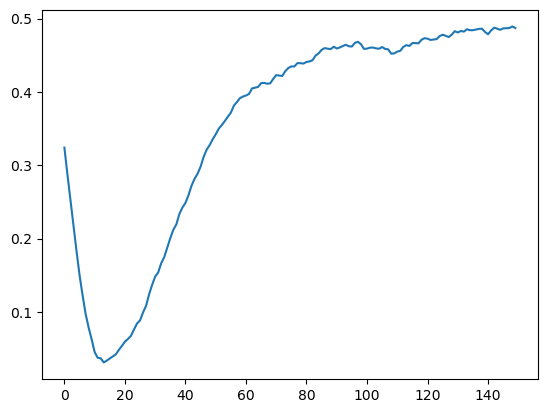

In [12]:
# Plot 3rd X_test window
plt.plot(data_dict["X_test_sc"][2, :])

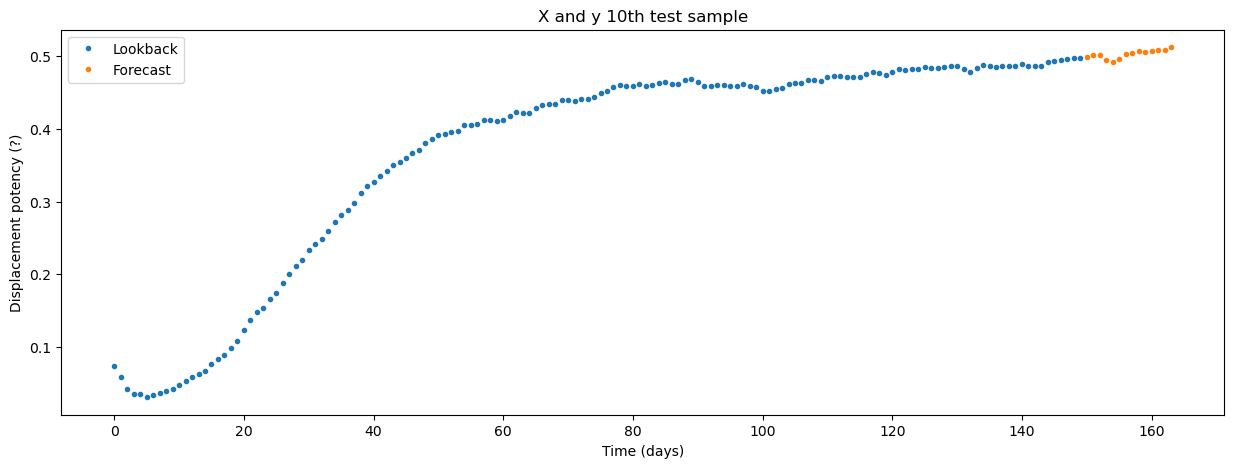

In [13]:
# Plot an example X and y sample
plt.figure(figsize=(15, 5))
plt.plot(data_dict["X_test_sc"][10], ".", label="Lookback")
# Plot the y sample shifted by the length of the lookback
plt.plot(np.arange(LOOKBACK, LOOKBACK + FORECAST), data_dict["y_test_sc"][10], ".", label="Forecast")
plt.title("X and y 10th test sample")
plt.xlabel("Time (days)")
plt.ylabel("Displacement potency (?)")
plt.legend()
plt.show()

## Modelling

In [16]:
# For LSTM config
N_VARIATES = 1
HIDDEN_SIZE = 50
N_LAYERS = 1
OUTPUT_SIZE = FORECAST

model = lstm.MultiStepLstmSingleLayer(N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE, device).to(device)

### Training

In [45]:
# For LSTM training
N_EPOCHS = 75
results_dict = lstm.train_lstm(model, N_EPOCHS, data_dict, scaler_y, device)

Epoch [75/75], Train RMSE: 0.0743, Test RMSE: 0.1310, Train R2: 0.9851, Test R2: 0.9798, Last Batch Loss: 0.0007: 100%|██████████| 75/75 [10:41<00:00,  8.55s/it]


## Results

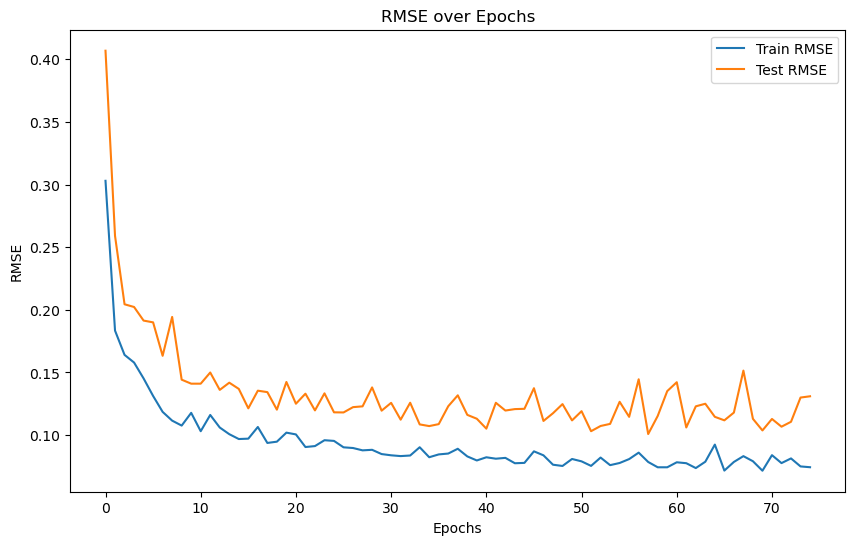

In [47]:
# Plot RMSE
gfn.plot_metric(N_EPOCHS, results_dict["train_rmse_list"], results_dict["test_rmse_list"], "RMSE")

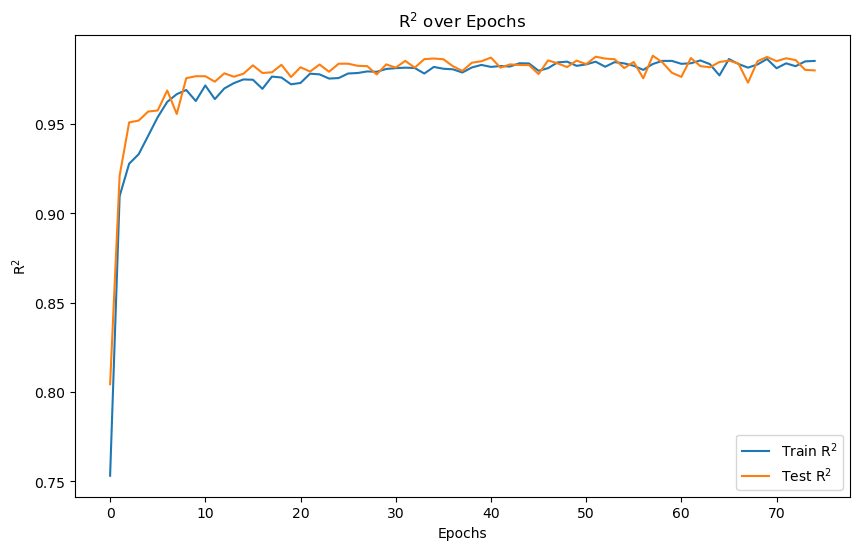

In [48]:
# Plot R2
gfn.plot_metric(N_EPOCHS, results_dict["train_r2_list"], results_dict["test_r2_list"], "R$^2$")

In [74]:
# Plot predictions against true values
TEST_START_IDX = len(df_smoothed) - len(y_test)
TITLE = "Original Time Series and Model Predictions of Segment 1 sum"
X_LABEL = "Time (days)"
Y_LABEL = "Displacement potency (?)"
ZOOM_MIN = 3600
ZOOM_MAX = 3800
ZOOM_WINDOW = [ZOOM_MIN, ZOOM_MAX]

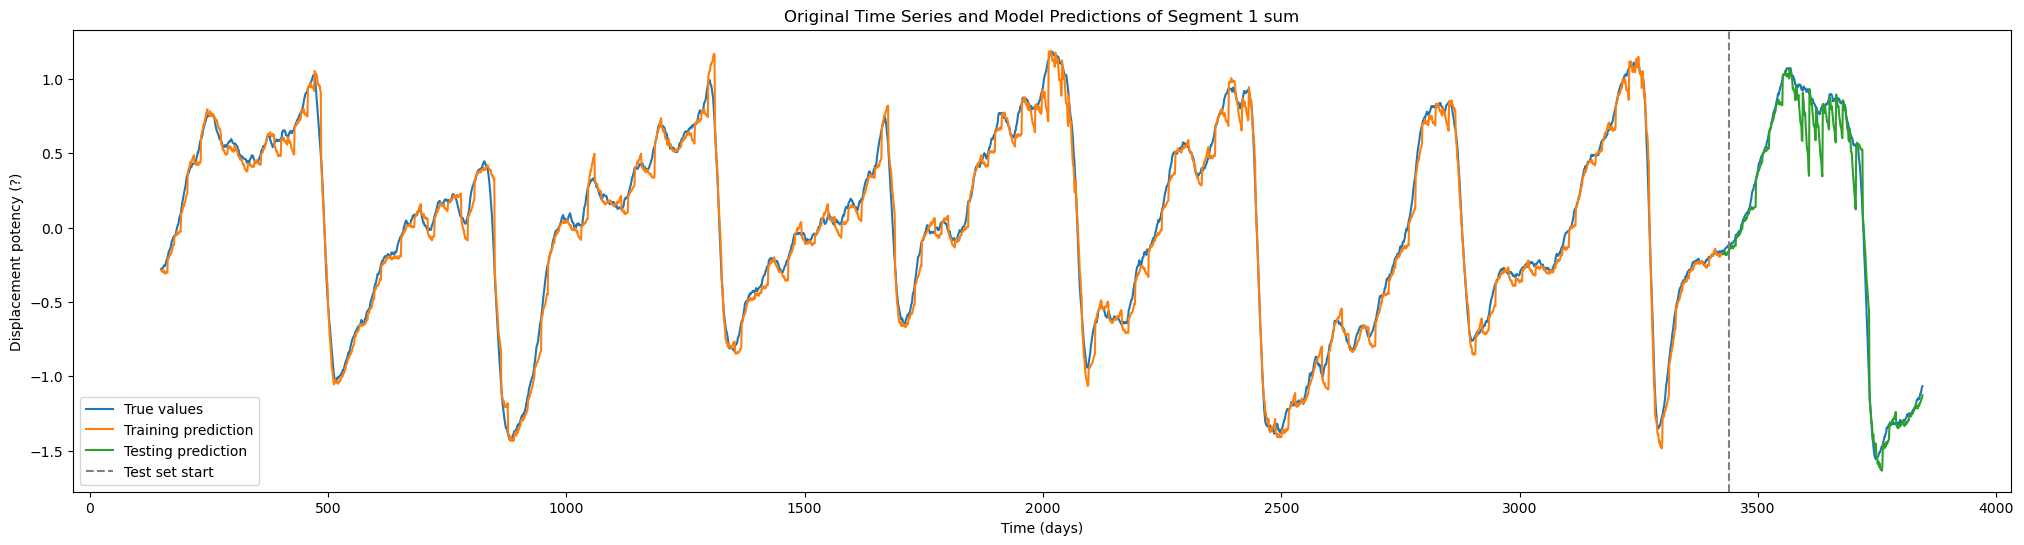

In [75]:
gfn.plot_all_data(TEST_START_IDX, data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, [])


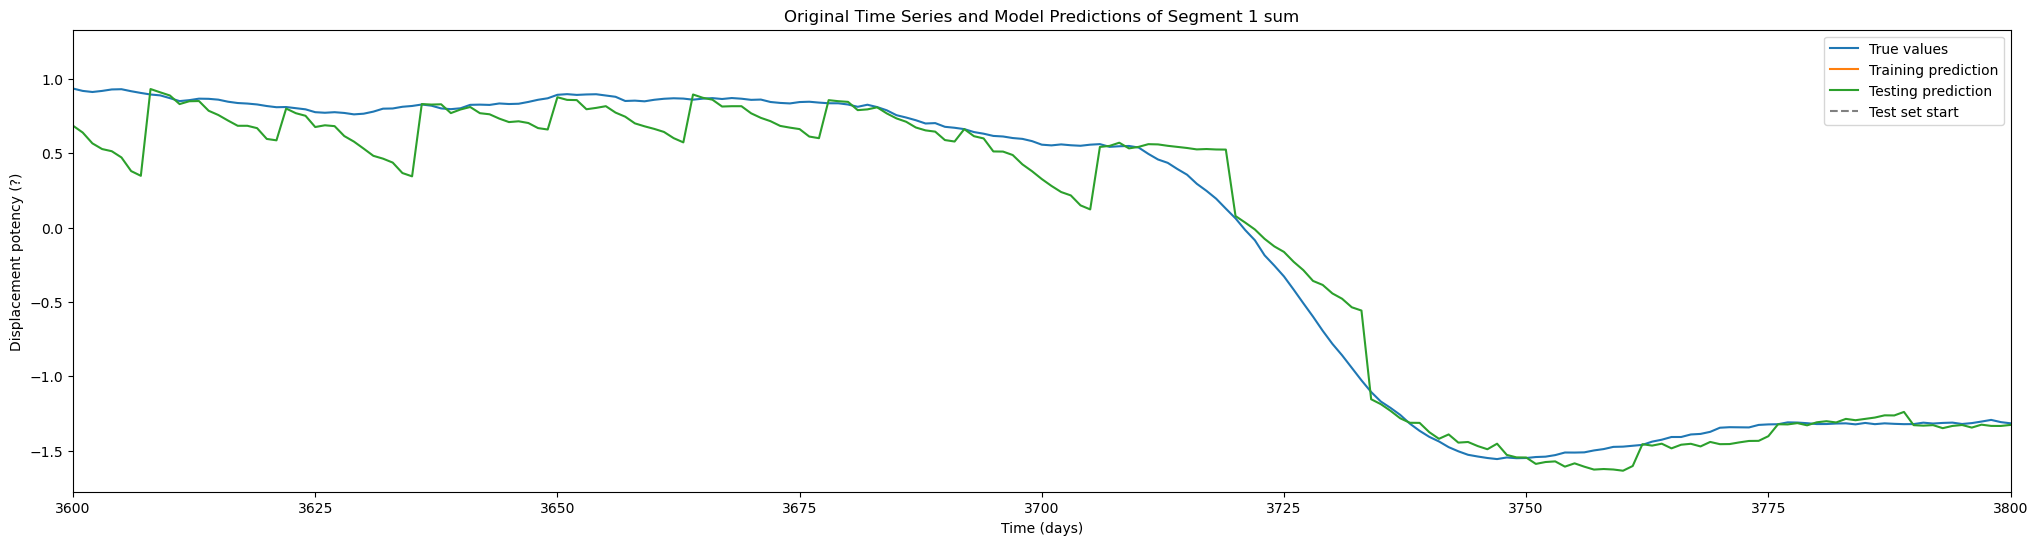

In [76]:
gfn.plot_all_data(TEST_START_IDX, data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, ZOOM_WINDOW)

## Pritt's LSTM

In [14]:
# For LSTM config
N_VARIATES = 1
HIDDEN_SIZE = 50
N_LAYERS = 1
OUTPUT_SIZE = FORECAST
model_multi_layer = lstm.MultiStepLstmMultiLayer(N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE, device).to(device)

In [15]:
# For LSTM training
N_EPOCHS = 75
results_dict_multi_layer = lstm.train_lstm(model_multi_layer, N_EPOCHS, data_dict, scaler_y, device)

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [75/75], Train RMSE: 0.0797, Test RMSE: 0.0962, Train R2: 0.9829, Test R2: 0.9891, Last Batch Loss: 0.0006: 100%|██████████| 75/75 [10:14<00:00,  8.20s/it]


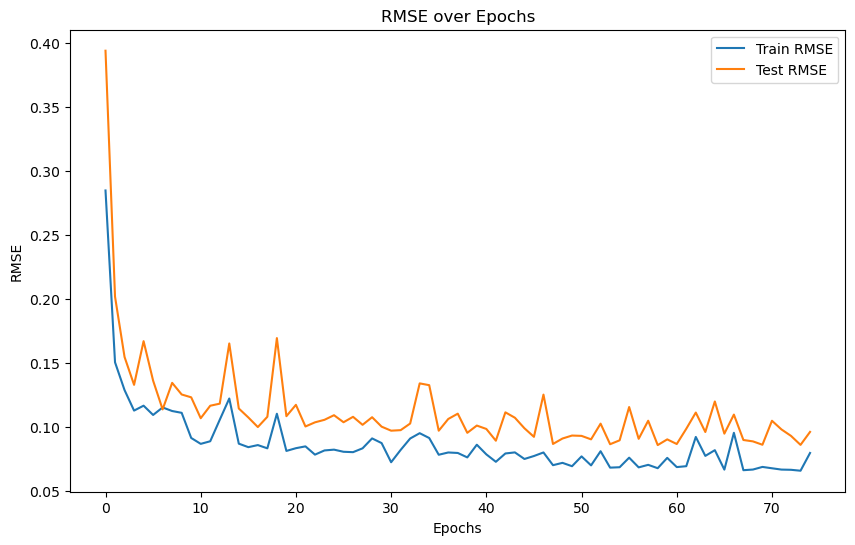

In [17]:
# Plot RMSE
gfn.plot_metric(N_EPOCHS, results_dict_multi_layer["train_rmse_list"], results_dict_multi_layer["test_rmse_list"], "RMSE")

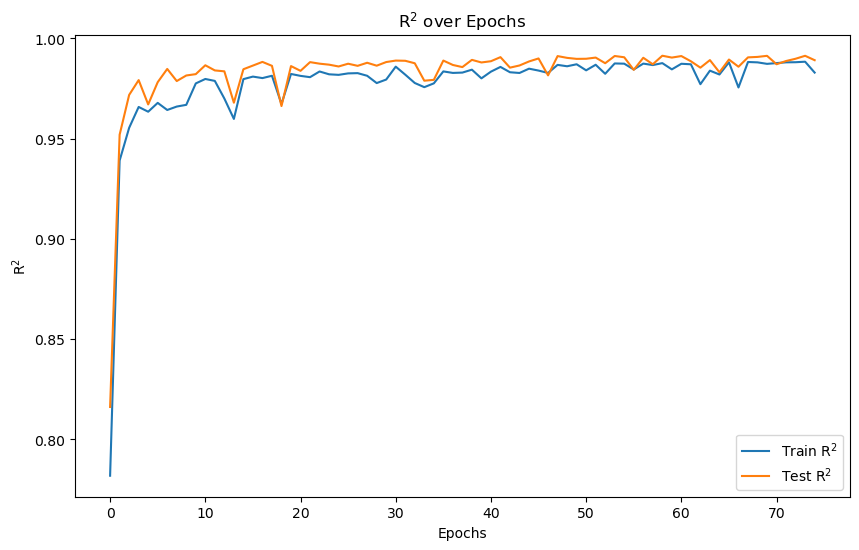

In [18]:
# Plot R2
gfn.plot_metric(N_EPOCHS, results_dict_multi_layer["train_r2_list"], results_dict_multi_layer["test_r2_list"], "R$^2$")

In [19]:
# Plot predictions against true values
TEST_START_IDX = len(df_smoothed) - len(y_test)
TITLE = "Original Time Series and Model Predictions of Segment 1 sum"
X_LABEL = "Time (days)"
Y_LABEL = "Displacement potency (?)"
ZOOM_MIN = 3600
ZOOM_MAX = 3800
ZOOM_WINDOW = [ZOOM_MIN, ZOOM_MAX]

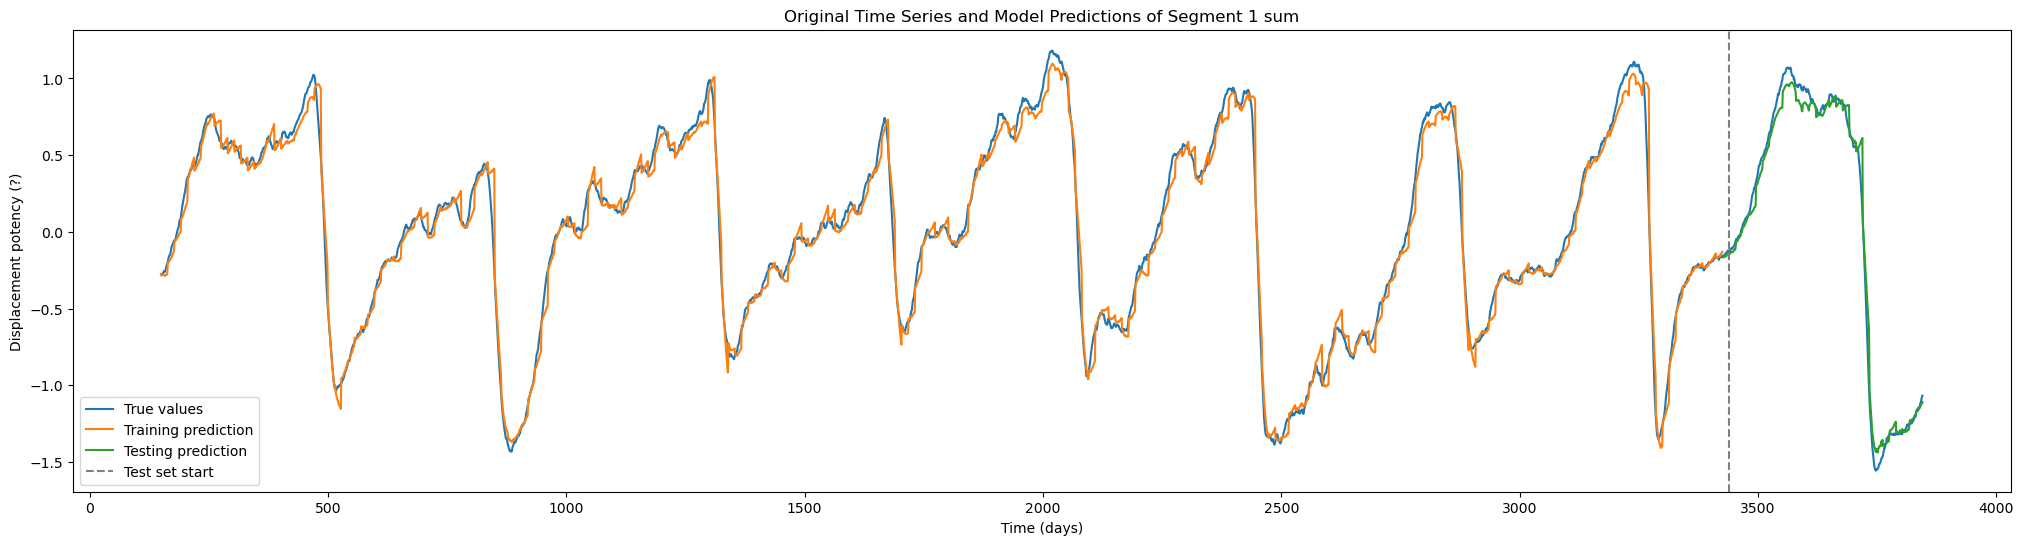

In [21]:
gfn.plot_all_data(TEST_START_IDX, data_dict, results_dict_multi_layer, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, [])

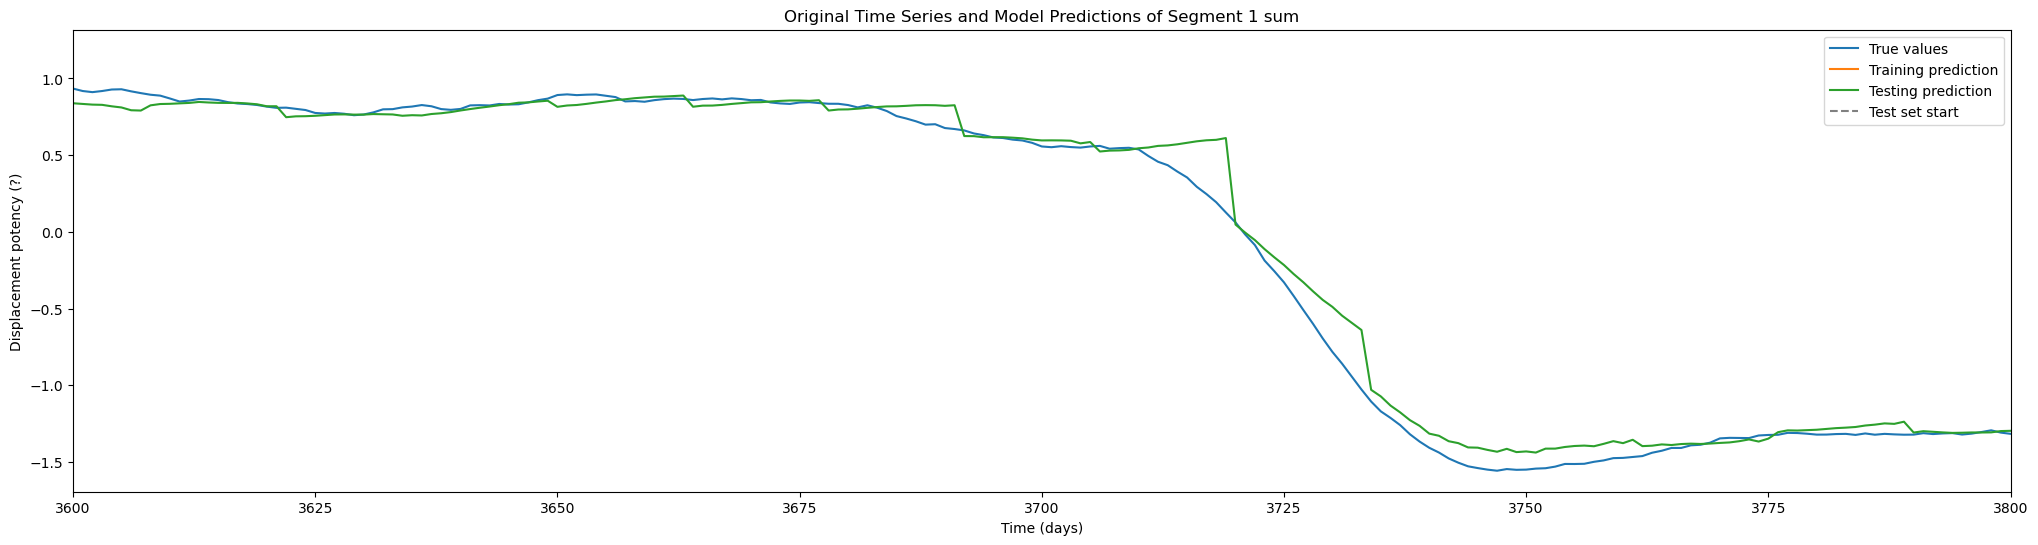

In [23]:
gfn.plot_all_data(TEST_START_IDX, data_dict, results_dict_multi_layer, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, ZOOM_WINDOW)